# 0) Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
import os
import socket
import numpy as np
import scipy as sp
from scipy.linalg import solve_sylvester, solve_lyapunov

from scipy.sparse import issparse
import math

from time import time

import matplotlib.pyplot as plt

# 1) Personal tools and solvers

In [4]:
from utils import is_symmetric, res_norm_syl
from plots import plot_conv, plot_eigenvals, plot_conv_plotly
from results import ResultSyl

from gen_data import gen_discrete_poisson_filtered, poisson_func, cheb_diff_mat
from adi_sylvester import adi_syl, sap_adi_syl, sap_adi_syl_sym, sap_adi_syl_decrease
from shift_parameters import shifts_adi_syl, shifts_adi_syl_one_iter

from save_load import save, save_poisson_filtered, load_poisson_filtered

# 2) Load input matrices from discretization of the Poisson equation
## $$\frac{\partial^2u}{\partial x^2} + \frac{\partial^2u}{\partial y^2} = f$$
## with the boundary condition $\partial u = 0$ and the right-hand side
## $f(x, y) = \cos(\omega x) \sin(\omega y)$ where $\omega = 10$.

### Parameters to select

In [32]:
N = 1000 # dimension

n_iter_opt_shifts = 100       # number iterations cst shifts
n_iter_cst_shifts = int(1e2)  # number iterations cst shifts
n_iter_bsadi = int(1e2)       # number iterations BSADI


fracs = [.1, .25, .9]

eps = 1e-3 # tolerance

overwrite = False  # overwrite matrices


is_mobius = True  # run with moving Mobius shift parameters
is_adi_opt = True  # run vanilla ADI with constant optimal shift = 1 step Mobius shift
is_adi_cst = True  # run vanilla ADI with constant shift = largest eigenvalue

# Very costly in high dimension
compute_sol = False  # compute solution
is_rel_err_plot = False  # compute relative error/distance to optimum and display corresponding plots

is_plot_spectrum = False # plot spectrum of matrices A and B


# Plots title
title = f"Poisson filtered problem N={N}"

## Load or generate data

In [33]:
filename = "poisson_filtered_" + str(N) + ".npz"
folder = os.path.join(os.getcwd(), "datasets/syl/")
path = os.path.join(folder, filename)

if os.path.exists(path) and not overwrite:
    A, C, X_true = load_poisson_filtered(N)
    B = -A.T
    if compute_sol and X_true.size == 0:
        X_true = solve_sylvester(A, -B, C)
        if res_norm_syl(X_true, A, B, C) >= 1e-3:
            warnings.warn("Impossible to compute solution of the Sylvester equation.")
            X_true = np.array([])
    print("Matrices loaded from\n", path)
else:
    omega = 10
    A, B, C, X_true = gen_discrete_poisson_filtered(N, omega=omega, compute_sol=compute_sol)
    save_poisson_filtered(A, C, X_true)
    print("Matrices saved in\n", path)
    
m = A.shape[0]
print("Shape of A :", m)

Matrices loaded from
 /home/nidham/phd/thomas_jefferson_fund/sketch_proj_ADI/code/sketched_adi/datasets/syl/poisson_filtered_1000.npz
Shape of A : 1000


In [34]:
if compute_sol:
    # Check that X_true is a solution
    error_norm = res_norm_syl(X_true, A, B, C)
    print(f"Error norm = {error_norm:.2e}")

    if X_true.size == 0:
        print("Solution not provided")
    else:
        if error_norm < 1e-3:
            print("The problem is well posed")
        else:
            print("The problem does not have a solution")
            X_true = np.array([])

## Plot Chebyshev second order differentiation matrix

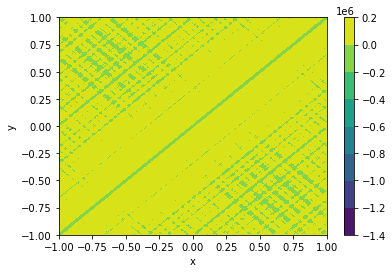

In [35]:
_, x = cheb_diff_mat(N+2, k=2)
X, Y = np.meshgrid(x, x)

F = np.pad(A, 1, mode='constant')

fig, ax = plt.subplots(1,1)
cp = ax.contourf(X, Y, F)
fig.colorbar(cp)  # add a colorbar to a plot
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()
# plt.savefig(f"outputs/poisson_filtered_N_{N}_chebyshev_second_order_matrix.pdf")

## Plot F

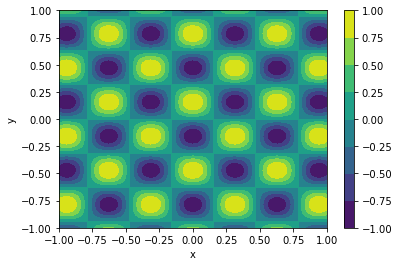

In [36]:
_, x = cheb_diff_mat(N+2, k=2)
X, Y = np.meshgrid(x, x)

F = np.pad(C, 1, mode='constant')

fig, ax = plt.subplots(1,1)
cp = ax.contourf(X, Y, F)
fig.colorbar(cp)  # add a colorbar to a plot
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()
# plt.savefig(f"outputs/poisson_filtered_N_{N}_rhs_F.pdf")

## Plot solution

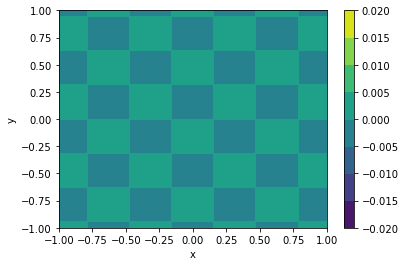

In [37]:
if not X_true.size == 0:
    _, x = cheb_diff_mat(N+2, k=2)
    x_grid, y_grid = np.meshgrid(x, x)

    X_solution = np.pad(X_true, 1, mode='constant')

    fig, ax = plt.subplots(1,1)
    cp = ax.contourf(x_grid, y_grid, X_solution)
    fig.colorbar(cp)  # add a colorbar to a plot
#     ax.set_title('Solution matrix on the [-1, 1] squared grid')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    plt.show()
#     plt.savefig(f"outputs/poisson_filtered_N_{N}_true_solution.pdf")

## Problem parameters

In [38]:
# Estimate eigenvalue interval
t0 = time()
# eig_val_A = np.linalg.eigvals(A)
# eig_val_B = np.linalg.eigvals(B)

# a = np.min(eig_val_A)
# b = np.max(eig_val_A)

# c = np.min(eig_val_B) # c = -b
# d = np.max(eig_val_B) # d = -a

a = - (math.pi * N) ** 2 / 4
b = - (math.pi * 1) ** 2 / 4
c = (math.pi * 1) ** 2 / 4
d = (math.pi * N) ** 2 / 4

t_eigvals = time() - t0


print(f"Spectrum of A: [{a:1.2e}, {b:.5f}]")
print(f"Spectrum of B: [{c:.5f}, {d:1.2e}]\n")


# print(f"a={a:1.2e}, b={b:.4f}, c={c:.4f}, d={d:1.2e}\n")

# print(f"Time numpy eigvalsh: {t_eigvals:.2} s")

Spectrum of A: [-2.47e+06, -2.46740]
Spectrum of B: [2.46740, 2.47e+06]



## Power iteration

In [39]:
def normalize(x):
    fac = abs(x).max()
    x_n = x / x.max()
    return fac, x_n

In [40]:
# t_power_method = 0.

# # nb_iter_power = 1000

# # t0 = time()
# # x = np.ones(m)
# # for i in range(nb_iter_power):
# #     x = B @ x
# #     lambda_max_B, x = normalize(x)

# # d_estimate, a_estimate = lambda_max_B, -lambda_max_B
# # t_power_method = time() - t0

# # print(f"d estimate : {d_estimate:.0f},   a estimate : {a_estimate:.0f}")
# print(f"N^2 * pi^2 / 4 : {(math.pi * N) ** 2 / 4:.0f},   -N^2 * pi^2 / 4 : {-(math.pi * N) ** 2 / 4:.0f}")
# print(f"d          : {d:.0f},   a          : {a:.0f}")

# print(f"Time power method: {t_power_method:.2} s")

## Plot spectrum

In [41]:
if is_plot_spectrum:
    # Plot eigenvalues decrease
    plot_eigenvals(eig_val_A, eig_val_B, "syl")

# 3) Compute different shifts strategy

## Compute constant shifts

In [42]:
# Constant shifts for ADI with preselected tolerance

# Around N^4
t0 = time()
p_cst, q_cst = d, a
# p_cst, q_cst = (math.pi * N) ** 2 / 4, -(math.pi * N) ** 2 / 4
# p_cst, q_cst = d_estimate, a_estimate
t_shifts_cst = time() - t0
# p_cst, q_cst = N**4, -N**4

# Largest module parameter from Mobius transform
# which is around N^4
# p_cst, q_cst = p_mob[0], q_mob[0]

print(f"Constant shift parameters: p={p_cst:.2e}, q={q_cst:.2e}\n")

# print(f"Time cst shift: {t_shifts_cst:.2} s")

Constant shift parameters: p=2.47e+06, q=-2.47e+06



## Constant optimal shifts for one ADI step

In [43]:
# Constant optimal shifts for one step of ADI with preselected tolerance

if is_adi_opt:
    t0 = time()
    p_opt, q_opt = shifts_adi_syl_one_iter(a, b, c, d, eps)
    t_shifts_opt = time() - t0
    print(f"Optimal shift parameters for one step: p={p_opt:.2e}, q={q_opt:.2e}\n")
    
    print(f"Time numpy eigvalsh: {t_shifts_opt:.2} s")

Optimal shift parameters for one step: p=2.47e+03, q=-2.47e+03

Time numpy eigvalsh: 0.0002 s


## Compute Mobius shifts

In [44]:
if is_mobius:
    # Optimal shifts for ADI with preselected tolerance
    t0 = time()
    gamma = (c-a)*(d-b)/(c-b)/(d-a)
    p_mob, q_mob, n_iter_mobius = shifts_adi_syl(a, b, c, d, eps)
    t_shifts_mobius = time() - t0
    
    print(f"gamma = {gamma:1.2e}")
    print(f"Number of iteration: {n_iter_mobius}\n")

    if any(np.isnan(p_mob)):
        is_mobius = False
        print("WARNING: Mobius shifts are NANs")
    else:
        print(f"Shift parameters given by Mobius transform:\n{p_mob} \n\n{q_mob}\n")
    
        print(f"Time numpy eigvalsh: {t_shifts_mobius:.2} s")
        # p decreases from d to c (0 < c < d)
        # q increases from a to b (a < b < 0)

gamma = 2.50e+05
Number of iteration: 13

Shift parameters given by Mobius transform:
[2.09839131e+06 8.29230855e+05 2.64477692e+05 8.23511697e+04
 2.55816150e+04 7.94488061e+03 2.46738745e+03 7.66279716e+02
 2.37983445e+02 7.39273149e+01 2.30189579e+01 7.34174423e+00
 2.90127052e+00] 

[-2.09839131e+06 -8.29230855e+05 -2.64477692e+05 -8.23511697e+04
 -2.55816150e+04 -7.94488061e+03 -2.46738745e+03 -7.66279716e+02
 -2.37983445e+02 -7.39273149e+01 -2.30189579e+01 -7.34174423e+00
 -2.90127052e+00]

Time numpy eigvalsh: 0.00022 s


In [45]:
print(f"Number of iterations for ADI with Mobius shifts: {n_iter_mobius}")
print(f"Number of iterations for ADI with constant shifts: {n_iter_cst_shifts}")
print(f"Number of iterations for BSADI: {n_iter_bsadi}")

Number of iterations for ADI with Mobius shifts: 13
Number of iterations for ADI with constant shifts: 100
Number of iterations for BSADI: 100


# 4) ADI to solve Sylvester equation

In [46]:
# List of outputs of the solvers 
results_deter = []

In [47]:
print("Warm start")
_, _, _, _ = adi_syl(
    A, B, C, 
    n_iter=2, 
    p=p_cst, q=q_cst, 
    store_every=1,
    verbose=True,
)

Warm start
--------------------------------------------
  Iteration   |    Epoch     |   Time (s)   
--------------------------------------------
      1       |      1       |   1.48e-01   
      2       |      2       |   2.77e-01   


# a) ADI with Mobius shifts

In [48]:
if is_mobius:
    print("Mobius shifts for ADI")
    X_adi_mob, t_adi_mob, iter_adi_mob, epoch_adi_mob = adi_syl(
        A, B, C, 
        n_iter=n_iter_mobius, 
        p=p_mob, q=q_mob, 
        store_every=int(math.ceil(n_iter_mobius/10)),
        verbose=True,
    )
    
    t_adi_mob += t_shifts_mobius
    
    result_adi_mob = ResultSyl(
        "ADI-mobius_shifts", 
        X_adi_mob, t_adi_mob, iter_adi_mob, epoch_adi_mob,
        X_true,
    )

    if is_rel_err_plot:
        result_adi_mob.compute_errors(A, B, C)  # very costly
    else:
        result_adi_mob.compute_residuals(A, B, C)

    results_deter.append(result_adi_mob)

    print(f"\nRelative residual of last iterate: {result_adi_mob.rel_res[-1]:.2e}")
    if not result_adi_mob.rel_err.size == 0:
        print(f"Relative error of last iterate: {result_adi_mob.rel_err[-1]:.2e}")

Mobius shifts for ADI
--------------------------------------------
  Iteration   |    Epoch     |   Time (s)   
--------------------------------------------
      2       |      2       |   2.57e-01   
      4       |      4       |   5.17e-01   
      6       |      6       |   7.80e-01   
      8       |      8       |   1.04e+00   
      10      |      10      |   1.31e+00   
      12      |      12      |   1.58e+00   
      13      |      13      |   1.71e+00   

Relative residual of last iterate: 2.52e-04


# b) ADI with constant optimal (for one ADI step) shifts

In [49]:
if is_adi_opt:
    print("Constant optimal shifts for ADI")
    X_adi_opt, t_adi_opt, iter_adi_opt, epoch_adi_opt = adi_syl(
        A, B, C, 
        n_iter=n_iter_opt_shifts, 
        p=p_opt, q=q_opt, 
        store_every=int(n_iter_opt_shifts/10),
        verbose=True,
    )
    
    t_adi_opt += t_shifts_opt

    result_adi_opt = ResultSyl(
        "ADI-cst-1_step_mobius", 
        X_adi_opt, t_adi_opt, iter_adi_opt, epoch_adi_opt,
        X_true,
    )
        
    if is_rel_err_plot:
        result_adi_opt.compute_errors(A, B, C)  # very costly
    else:
        result_adi_opt.compute_residuals(A, B, C)
    
    results_deter.append(result_adi_opt)

    print(f"\nRelative residual of last iterate: {result_adi_opt.rel_res[-1]:.2e}")
    if not result_adi_opt.rel_err.size == 0:
        print(f"Relative error of last iterate: {result_adi_opt.rel_err[-1]:.2e}")

Constant optimal shifts for ADI
--------------------------------------------
  Iteration   |    Epoch     |   Time (s)   
--------------------------------------------
      10      |      10      |   1.30e+00   
      20      |      20      |   2.57e+00   
      30      |      30      |   3.84e+00   
      40      |      40      |   5.27e+00   
      50      |      50      |   6.69e+00   
      60      |      60      |   8.27e+00   
      70      |      70      |   9.85e+00   
      80      |      80      |   1.13e+01   
      90      |      90      |   1.26e+01   
     100      |     100      |   1.39e+01   

Relative residual of last iterate: 6.31e-01


# c) ADI with constant (largest eigenvalue) shifts

In [50]:
if is_adi_cst:
    print("Constant shifts for ADI")
    X_adi_cst, t_adi_cst, iter_adi_cst, epoch_adi_cst = adi_syl(
        A, B, C, 
        n_iter=n_iter_cst_shifts, 
        p=p_cst, q=q_cst, 
        store_every=int(n_iter_cst_shifts/10),
        verbose=True,
    )
    
    t_adi_cst += t_shifts_cst

    result_adi_cst = ResultSyl(
        "ADI-cst", 
        X_adi_cst, t_adi_cst, iter_adi_cst, epoch_adi_cst,
        X_true,
    )
    
    if is_rel_err_plot:
        result_adi_cst.compute_errors(A, B, C)  # very costly
    else:
        result_adi_cst.compute_residuals(A, B, C)

    results_deter.append(result_adi_cst)

    print(f"\nRelative residual of last iterate: {result_adi_cst.rel_res[-1]:.2e}")
    if not result_adi_cst.rel_err.size == 0:
        print(f"Relative error of last iterate: {result_adi_cst.rel_err[-1]:.2e}")

Constant shifts for ADI
--------------------------------------------
  Iteration   |    Epoch     |   Time (s)   
--------------------------------------------
      10      |      10      |   1.38e+00   
      20      |      20      |   2.65e+00   
      30      |      30      |   4.05e+00   
      40      |      40      |   5.29e+00   
      50      |      50      |   6.53e+00   
      60      |      60      |   7.77e+00   
      70      |      70      |   9.04e+00   
      80      |      80      |   1.04e+01   
      90      |      90      |   1.19e+01   
     100      |     100      |   1.31e+01   

Relative residual of last iterate: 6.09e-03


# d) BSADI with constant (largest eigenvalue) shifts

In [51]:
results_rnd = []

In [52]:
for size_frac in fracs:
    m = A.shape[0]
    n = B.shape[0]
    min_size = min(m, n)
    sketch_size = int(size_frac * min_size)
        
    n_iter_sto = int(n_iter_bsadi/size_frac)
    print(f"Problem of size: m={m} and n={n} | sketch dimension: {sketch_size} ({int(100*size_frac)}% of rows)")
    print(f"Number of iterations: {n_iter_sto}")

    np.random.seed(0)
    X_sketch_cst, t_sketch_cst, iter_sketch_cst, epoch_sketch_cst = sap_adi_syl(
        A, B, C, 
        n_iter=n_iter_sto, 
        p=p_cst, q=q_cst,
        sketch_size=sketch_size, 
        store_every=int(n_iter_sto/10),
        verbose=True,
    )
    
    t_sketch_cst += t_shifts_cst

    result_sketch_cst = ResultSyl(
        "BSADI-cst-" + str(size_frac),
        X_sketch_cst, t_sketch_cst, iter_sketch_cst, epoch_sketch_cst,
        X_true,
    )

    if is_rel_err_plot:
        result_sketch_cst.compute_errors(A, B, C)  # very costly
    else:
        result_sketch_cst.compute_residuals(A, B, C)
    
    results_rnd.append(result_sketch_cst)

    print(f"\nRelative residual of last iterate: {result_sketch_cst.rel_res[-1]:.2e}")
    if not result_sketch_cst.rel_err.size == 0:
        print(f"Relative error of last iterate: {result_sketch_cst.rel_err[-1]:.2e}")
    print("\n")

Problem of size: m=1000 and n=1000 | sketch dimension: 100 (10% of rows)
Number of iterations: 1000
Sketch size equals 100 for both matrices A and B

--------------------------------------------
  Iteration   |    Epoch     |   Time (s)   
--------------------------------------------
     100      |     10.0     |   3.68e+00   
     200      |     20.0     |   6.45e+00   
     300      |     30.0     |   9.76e+00   
     400      |     40.0     |   1.27e+01   
     500      |     50.0     |   1.53e+01   
     600      |     60.0     |   1.87e+01   
     700      |     70.0     |   2.25e+01   
     800      |     80.0     |   2.74e+01   
     900      |     90.0     |   3.05e+01   
     1000     |    100.0     |   3.31e+01   

Relative residual of last iterate: 6.03e-03


Problem of size: m=1000 and n=1000 | sketch dimension: 250 (25% of rows)
Number of iterations: 400
Sketch size equals 250 for both matrices A and B

--------------------------------------------
  Iteration   |    Epoch

## Symmetric version (same rows sampled for both half steps) seems less efficient

In [53]:
results = results_deter + results_rnd

## Plot approximative solution

In [54]:
# for r in results:
#     last_iterate = r.iterates[-1]
#     X_sol = np.pad(last_iterate, 1, mode='constant')

#     fig, ax = plt.subplots(1,1)
#     cp = ax.contourf(X, Y, X_solution)
#     fig.colorbar(cp)  # add a colorbar to a plot
#     ax.set_title(r.algo_name + " solution")
# #     ax.set_xlabel('x')
# #     ax.set_ylabel('y')
#     plt.show()

# 5) Compare convergence plots: iterations and time

In [55]:
plot_conv_plotly(results_deter + results_rnd, title, prob="syl", x_axis="epoch")
plot_conv_plotly(results_deter + results_rnd, title, prob="syl", x_axis="time")

# 6) Save the results in csv and corresponding plots

In [58]:
machine = socket.gethostname()
exp_name = f"poisson_filtered_N_{N}_iter_bsadi_{n_iter_bsadi}_eps_{eps}_thesis_{machine}"
# exp_name = f"poisson_filtered_N_{N}_iter_bsadi_{n_iter_bsadi}_eps_{eps}_thesis"
save(results, title, "syl", exp_name)

Full path: /home/nidham/phd/thomas_jefferson_fund/sketch_proj_ADI/code/sketched_adi/outputs/syl/poisson_filtered_N_1000_iter_bsadi_100_eps_0.001_thesis_nidham-Latitude-7390
Save results in csv
Save plots
